In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

%matplotlib inline

from google.protobuf import text_format
from numba import cuda

In [ ]:
# Define the image size you want for your model
target_size = (1000, 1000)

# Define the batch size for training
batch_size = 8

# Define the path to the main dataset directory
dataset_dir = '/content/drive/MyDrive/dissertation_project/wheat_dataset'

# Define the exact paths to your dataset directories
train_image_dir = '/content/drive/MyDrive/dissertation_project/wheat_dataset/images/train'
train_annotation_dir = '/content/drive/MyDrive/dissertation_project/wheat_dataset/annotations/train'
test_image_dir = '/content/drive/MyDrive/dissertation_project/wheat_dataset/images/test'
test_annotation_dir = '/content/drive/MyDrive/dissertation_project/wheat_dataset/annotations/test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import xml.etree.ElementTree as ET
import pandas as pd


# Define a function to load Pascal VOC annotations
def load_annotations(image_dir, annotation_dir):
    annotations = []
    for xml_file in os.listdir(annotation_dir):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(annotation_dir, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            filename = root.find("filename").text
            image_path = os.path.join(image_dir, filename)
            boxes = []
            classes = []
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                box = obj.find("bndbox")
                xmin = int(float(box.find("xmin").text))  # Convert float to int
                ymin = int(float(box.find("ymin").text))  # Convert float to int
                xmax = int(float(box.find("xmax").text))  # Convert float to int
                ymax = int(float(box.find("ymax").text))  # Convert float to int
                boxes.append((xmin, ymin, xmax, ymax))
                classes.append(class_name)
            annotations.append({"image_path": image_path, "boxes": boxes, "classes": classes})
    return annotations

# Load annotations for the train, validation, and test datasets
train_annotations = load_annotations(train_image_dir, train_annotation_dir)
test_annotations = load_annotations(test_image_dir, test_annotation_dir)

# Convert the annotations to DataFrames
train_df = pd.DataFrame(train_annotations)
test_df = pd.DataFrame(test_annotations)

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create an ImageDataGenerator for validation and testing data (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


# Load and augment the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col=["boxes", "classes"],
    target_size=target_size,
    batch_size=batch_size,
    class_mode="multi_output",
    shuffle=True
)

# Load the test data
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col=["boxes", "classes"],
    target_size=target_size,
    batch_size=batch_size,
    class_mode="multi_output",
    shuffle=False  # No need to shuffle test data
)

Found 944 validated image filenames.
Found 105 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:991: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._targets = [np.array(df[col].tolist()) for col in y_col]


In [ ]:
train_df.head()

,image_path,boxes,classes
0,/content/drive/MyDrive/dissertation_project/wh...,"[(266, 700, 317, 804), (182, 795, 272, 884), (...","[wheat_mildew, wheat_mildew, wheat_mildew, whe..."
1,/content/drive/MyDrive/dissertation_project/wh...,"[(361, 117, 405, 148), (408, 142, 472, 170), (...","[wheat_mildew, wheat_mildew, wheat_mildew, whe..."
2,/content/drive/MyDrive/dissertation_project/wh...,"[(224, 572, 256, 601), (284, 616, 318, 632), (...","[wheat_mildew, wheat_mildew, wheat_mildew, whe..."
3,/content/drive/MyDrive/dissertation_project/wh...,"[(729, 435, 767, 480), (663, 490, 714, 544)]","[wheat_mildew, wheat_mildew]"
4,/content/drive/MyDrive/dissertation_project/wh...,"[(476, 487, 543, 563), (526, 636, 549, 663), (...","[wheat_mildew, wheat_mildew, wheat_mildew, whe..."


In [ ]:
'''import os
import io
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf
from object_detection.utils import dataset_util

def class_text_to_int(class_text):
    if class_text == 'wheat_septoria':
        return 1
    elif class_text == 'wheat_brown_rust':
        return 2
    elif class_text == 'wheat_mildew':
        return 3
    # Add more class mappings here as needed
    else:
        return None  # Return None for unknown classes

def create_tf_example(xml_path, image_dir):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    with tf.io.gfile.GFile(os.path.join(image_dir, root.find("filename").text), 'rb') as fid:
        encoded_jpg = fid.read()

    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = root.find("filename").text.encode('utf8')
    image_format = b'jpg'
    xmins, xmaxs, ymins, ymaxs = [], [], [], []
    classes_text, classes = [], []

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        classes_text.append(class_name.encode('utf8'))
        classes.append(class_text_to_int(class_name))
        bbox = obj.find("bndbox")
        xmins.append(float(bbox.find("xmin").text) / width)
        xmaxs.append(float(bbox.find("xmax").text) / width)
        ymins.append(float(bbox.find("ymin").text) / height)
        ymaxs.append(float(bbox.find("ymax").text) / height)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))

    return tf_example

def create_tf_records(output_path, image_dir, xml_dir):
    writer = tf.io.TFRecordWriter(output_path)
    xml_files = os.listdir(xml_dir)

    for xml_file in xml_files:
        xml_path = os.path.join(xml_dir, xml_file)
        tf_example = create_tf_example(xml_path, image_dir)
        writer.write(tf_example.SerializeToString())

    writer.close()
    print(f'Successfully created the TFRecord file: {output_path}')




image_dir = validation_image_dir
xml_annotation_dir = validation_annotation_dir
output_path = '/content/drive/MyDrive/Rcnn/wheat_dataset/validation.tfrecord'
'''

'import os\nimport io\nimport xml.etree.ElementTree as ET\nimport pandas as pd\nimport tensorflow as tf\nfrom object_detection.utils import dataset_util\n\ndef class_text_to_int(class_text):\n    if class_text == \'wheat_septoria\':\n        return 1\n    elif class_text == \'wheat_brown_rust\':\n        return 2\n    elif class_text == \'wheat_mildew\':\n        return 3\n    # Add more class mappings here as needed\n    else:\n        return None  # Return None for unknown classes\n\ndef create_tf_example(xml_path, image_dir):\n    tree = ET.parse(xml_path)\n    root = tree.getroot()\n\n    with tf.io.gfile.GFile(os.path.join(image_dir, root.find("filename").text), \'rb\') as fid:\n        encoded_jpg = fid.read()\n\n    encoded_jpg_io = io.BytesIO(encoded_jpg)\n    image = Image.open(encoded_jpg_io)\n    width, height = image.size\n\n    filename = root.find("filename").text.encode(\'utf8\')\n    image_format = b\'jpg\'\n    xmins, xmaxs, ymins, ymaxs = [], [], [], []\n    classes_t

In [ ]:
#create_tf_records(output_path, image_dir, xml_annotation_dir)

In [ ]:
len(test_generator)

14

In [ ]:
# Print the number of samples in each set (train, validation, test)
print("Number of training samples:", train_generator.samples)
#print("Number of validation samples:", validation_generator.samples)
print("Number of test samples:", test_generator.samples)

# Get the class labels for multi-label classification
class_labels = set(clas for classes in train_df["classes"] for clas in classes)
print("Class labels:", class_labels)

# Get the number of classes
num_classes = len(class_labels)
print("Number of classes:", num_classes)

# Get the class names (convert the set to a list)
class_names = list(class_labels)
print("Class names:", class_names)

# Get the image input shape
input_shape = train_generator.image_shape
print("Image input shape:", input_shape)

# Get the batch size
print("Batch size:", train_generator.batch_size)

# Check if data is shuffled
print("Is data shuffled:", train_generator.shuffle)

# Get the data augmentation parameters
data_augmentation_parameters = train_datagen.get_random_transform(input_shape)
print("Data augmentation parameters:", data_augmentation_parameters)

# Check the number of steps per epoch (useful for training)
steps_per_epoch = len(train_generator)
print(f"Steps per epoch: {steps_per_epoch}")

Number of training samples: 944
Number of test samples: 105
Class labels: {'wheat_mildew', 'wheat_brown_rust', 'wheat_septoria'}
Number of classes: 3
Class names: ['wheat_mildew', 'wheat_brown_rust', 'wheat_septoria']
Image input shape: (1000, 1000, 3)
Batch size: 8
Is data shuffled: True
Data augmentation parameters: {'theta': 13.617961596531096, 'tx': 68.85974244456573, 'ty': -76.97192223714292, 'shear': -0.19463218021718603, 'zx': 0.9965434026852552, 'zy': 0.8446008339862676, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}
Steps per epoch: 118


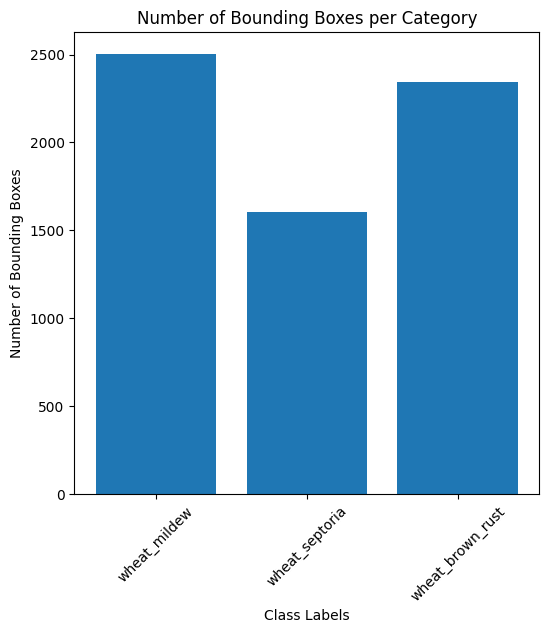

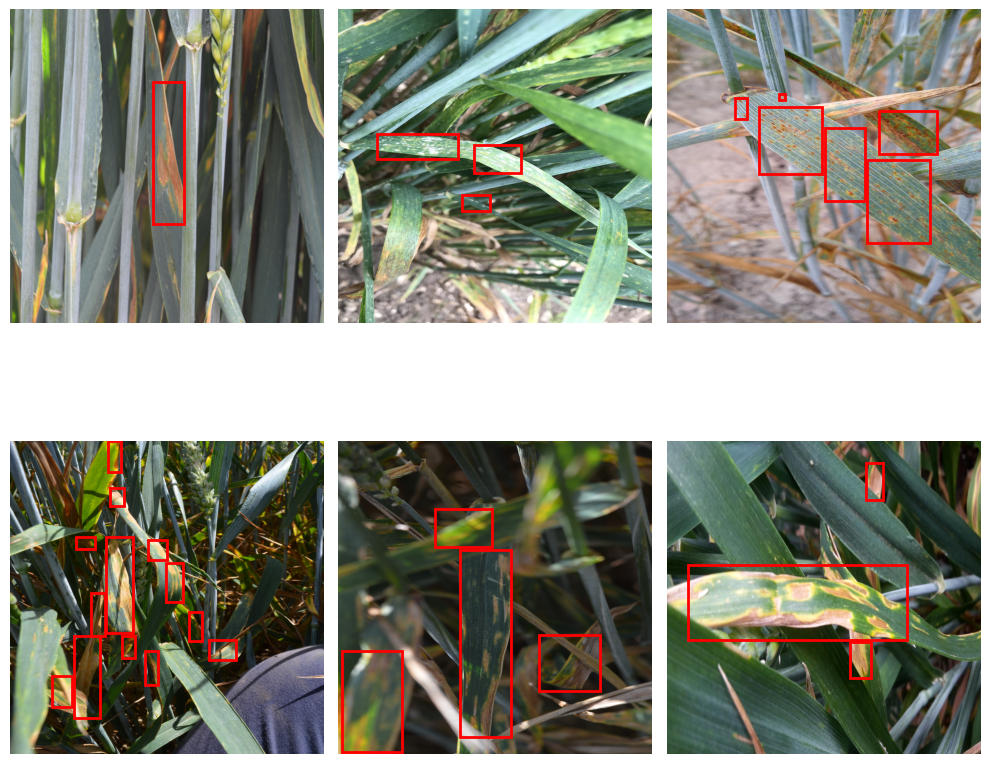

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Flatten the list of classes in the DataFrame
all_classes = [cls for classes in train_df["classes"] for cls in classes]

# Count the number of bounding boxes per category
from collections import Counter
bbox_counts = dict(Counter(all_classes))

# Plot the number of bounding boxes per category
plt.figure(figsize=(6, 6))
plt.bar(bbox_counts.keys(), bbox_counts.values())
plt.xlabel("Class Labels")
plt.ylabel("Number of Bounding Boxes")
plt.title("Number of Bounding Boxes per Category")
plt.xticks(rotation=45)
plt.show()

# Visualize sample images with bounding boxes
random_samples = random.sample(train_annotations, 6)  # Change 6 to the number of samples you want to visualize

fig, axes = plt.subplots(2, 3, figsize=(10, 10))

for i, sample in enumerate(random_samples):
    image_path = sample["image_path"]
    image = plt.imread(image_path)
    boxes = sample["boxes"]

    row, col = i // 3, i % 3
    ax = axes[row, col]

    ax.imshow(image)
    #ax.set_title(f"Image with Bounding Boxes ({', '.join(sample['classes'])})")

    for box in boxes:
        xmin, ymin, xmax, ymax = box
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))

    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.applications import ResNet101
import numpy as np

# Define the input size for your images (use your specified image size)
input_size = target_size  # Use the image size you've defined

# Step 1: Create Backbone Network
#backbone = ResNet101(weights='imagenet', include_top=False, input_shape=target_size + (3,))
# Define the EfficientNetV2 backbone
backbone = EfficientNetV2B2(
    include_top=False,
    weights='imagenet',
    input_shape=(1000, 1000, 3),
    pooling=None,
)

# Step 2: Define Anchor Boxes
# Define a list of base anchor sizes with different aspect ratios
scales = [18, 32, 64, 128, 256]

# Define a list of aspect ratios for anchor boxes (e.g., square and rectangle)
ratios = [(0.5, 1.0), (1.0, 1.0), (1.5, 0.5), (0.5, 1.5), (1.0, 2.0), (2.0, 1.0)]

# Calculate the number of anchor boxes
num_anchors = len(scales) * len(ratios)

# Generate anchor boxes for the RPN
anchor_box = layers.AnchorBoxes(scales=scales, aspect_ratios=ratios, name='anchor_boxes')(backbone.output)

# Reshape the anchor boxes to match the feature map dimensions
output_shape = tf.keras.backend.int_shape(backbone.output)
anchor_box = layers.Reshape((output_shape[1] * output_shape[2] * num_anchors, 4), name='reshape')(anchor_box)

# Define the Region Proposal Network (RPN)
rpn = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(backbone.output)
rpn_class = layers.Conv2D(num_anchors, (1, 1), activation='sigmoid')(rpn)
rpn_reg = layers.Conv2D(num_anchors * 4, (1, 1), activation='linear')(rpn)

# Define the RoI pooling or RoI align layer (adjust the output size)
roi_pooling = layers.MaxPooling2D(pool_size=(7, 7))(backbone.output)

# Define the classification and regression heads for object detection
x = layers.Flatten()(roi_pooling)
x = layers.Dense(1024, activation='relu')(x)

# Classification head
class_logits = layers.Dense(num_classes, activation='softmax')(x)

# Regression head
bbox_reg = layers.Dense(num_classes * 4, activation='linear')(x)

# Create the Faster R-CNN model
model = models.Model(inputs=backbone.input, outputs=[anchor_box, rpn_class, rpn_reg, class_logits, bbox_reg])




# Initialize a list to store anchor boxes
anchor_boxes = []

# Generate anchor boxes for different sizes and aspect ratios
for base_size in base_sizes:
    for aspect_ratio in aspect_ratios:
        width = base_size[0] * aspect_ratio[0]
        height = base_size[1] * aspect_ratio[1]

        # Calculate the coordinates of the anchor boxes
        x_center = 0.0  # You can modify this to suit your needs
        y_center = 0.0  # You can modify this to suit your needs

        x_min = x_center - 0.5 * (width - 1)
        y_min = y_center - 0.5 * (height - 1)
        x_max = x_center + 0.5 * (width - 1)
        y_max = y_center + 0.5 * (height - 1)

        anchor_boxes.append([x_min, y_min, x_max, y_max])

# Convert the list of anchor boxes to a NumPy array
anchor_boxes = np.array(anchor_boxes)

# Define the number of classes (use the number of classes you've defined)
num_classes = num_classes

# Create the region proposal network (RPN)
rpn = layers.Conv2D(len(anchor_boxes), (1, 1), activation='sigmoid', name='rpn')(backbone.output)

# Define the classification head
x_class = layers.GlobalAveragePooling2D()(backbone.output)
x_class = layers.Dense(num_classes, activation='softmax', name='classification')(x_class)

# Define the regression head
x_regress = layers.GlobalAveragePooling2D()(backbone.output)
x_regress = layers.Dense(len(anchor_boxes) * 4, activation='linear', name='regression')(x_regress)

# Create the Faster R-CNN model
model = keras.models.Model(
    inputs=backbone.input,
    outputs=[rpn, x_class, x_regress],
)

# Compile the model with suitable loss functions and metrics
model.compile(
    loss=[
        'binary_crossentropy',  # RPN classification loss
        'categorical_crossentropy',  # Classification loss
        'mean_squared_error',  # Regression loss
    ],
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics={
        'rpn': 'accuracy',
        'classification': 'accuracy',
    },
)

# Print a summary of the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1000, 1000, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 1000, 1000, 3)        0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 1000, 1000, 3)        0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 500, 500, 32)         864       ['normalization_1[0][0]'] 

In [ ]:
# Define the number of epochs and steps per epoch
num_epochs = 10  # Adjust the number of training epochs
steps_per_epoch = len(train_generator)  # Adjust this based on your data and batch size

# Start the training loop
for epoch in range(num_epochs):
    for step in range(steps_per_epoch):
        # Load a batch of training data using the generator
        batch = next(train_generator)
        images = batch[0]
        targets = batch[1]

        # Split the targets into class labels and regression labels
        class_labels, regression_labels = targets

        # Train the model on the batch
        loss = model.train_on_batch(images, {'rpn': regression_labels, 'classification': class_labels})

        # Print the loss for monitoring
        print(f'Epoch {epoch + 1}/{num_epochs}, Step {step + 1}/{steps_per_epoch}, Loss: {loss}')

# Save the trained model for future use
model.save('faster_rcnn_model.h5')


ValueError: ignored